<a href="https://colab.research.google.com/github/Black-bird14/robot_task_scheduling/blob/main/Robot_Task_Scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
The Simulation Setup has been majorly inspired from the following repository
@misc{SayCan,
  author = {Michael Ahn et al.},
  title = {SayCan},
  year = {2022},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished = {\url{https://github.com/google-research/google-research/blob/master/saycan/SayCan-Robot-Pick-Place.ipynb}},
  commit = {8c56e5dfc49613a57b80d6cfa2c9d6605cc08d10}
}
'''

In [1]:
#@title Installing and Downloading all necessary packages and assets

!pip install ftfy regex tqdm fvcore imageio imageio-ffmpeg
!pip install git+https://github.com/openai/CLIP.git
!pip install -U --no-cache-dir gdown --pre
!pip install pybullet moviepy
#!pip install jax==0.4.13
#!pip install optax==0.1.2
#!pip install chex==0.1.2
#!pip install flax==0.5.3
!pip install --upgrade git+https://github.com/google/flax
#!pip install git+https://github.com/google-deepmind/optax.git
#!python -m pip install jax jaxlib
!pip install huggingface
!pip install easydict
!pip install imageio-ffmpeg
#!pip install --upgrade jax jaxlib

#!pip install tensorflow==2.7.0 # If error: UNIMPLEMENTED: DNN library is not found.
#!pip install jax

import collections
import datetime
import os
import random
import threading
import time

import cv2  # Used by ViLD.
import clip
from easydict import EasyDict
import flax
#import jax.numpy as jnp
from flax import linen as nn
from flax.training import checkpoints
from flax.metrics import tensorboard
import imageio
from heapq import nlargest
import IPython
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import numpy as np
#import openai
#import optax
import pickle
from PIL import Image
import pybullet
import pybullet_data
import tensorflow.compat.v1 as tf
import torch
from tqdm import tqdm

#Download PyBullet assets.
if not os.path.exists('ur5e/ur5e.urdf'):
  !gdown --id 1Cc_fDSBL6QiDvNT4dpfAEbhbALSVoWcc
  !gdown --id 1yOMEm-Zp_DL3nItG9RozPeJAmeOldekX
  !gdown --id 1GsqNLhEl9dd4Mc3BM0dX3MibOI1FVWNM
  !unzip ur5e.zip
  !unzip robotiq_2f_85.zip
  !unzip bowl.zip

# ViLD pretrained model weights.
!gsutil cp -r gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2 ./

%load_ext tensorboard


# Show useful GPU info.
!nvidia-smi

# Show if JAX is using GPU.
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=1860e4eb5be7ba06c2b7ad70a191a242c1398af7223e5b0e05a46f9e961ee4e1
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=7f00830f3f99771a6ad11980c98f89ce0f6872621473a531392aaef31f1519f0
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-b5jvqo7g
  Running command git clone --filter=blob

In [2]:
#@title Global constants: pick and place objects, colors, workspace bounds

PICK_TARGETS = {
  "blue block": None,
  "red block": None,
  "green block": None,
  "yellow block": None,
}

COLORS = {
    "blue":   (78/255,  121/255, 167/255, 255/255),
    "red":    (255/255,  87/255,  89/255, 255/255),
    "green":  (89/255,  169/255,  79/255, 255/255),
    "yellow": (237/255, 201/255,  72/255, 255/255),
}

PLACE_TARGETS = {
  "blue block": None,
  "red block": None,
  "green block": None,
  "yellow block": None,

  "blue bowl": None,
  "red bowl": None,
  "green bowl": None,
  "yellow bowl": None,

  "top left corner":     (-0.3 + 0.05, -0.2 - 0.05, 0),
  "top right corner":    (0.3 - 0.05,  -0.2 - 0.05, 0),
  "middle":              (0,           -0.5,        0),
  "bottom left corner":  (-0.3 + 0.05, -0.8 + 0.05, 0),
  "bottom right corner": (0.3 - 0.05,  -0.8 + 0.05, 0),
}

PIXEL_SIZE = 0.00267857
BOUNDS = np.float32([[-0.3, 0.3], [-0.8, -0.2], [0, 0.15]])  # X Y Z

In [3]:
#@title Gripper (Robotiq 2F85) code

class Robotiq2F85:
  """Gripper handling for Robotiq 2F85."""

  def __init__(self, robot, tool):
    self.robot = robot
    self.tool = tool
    pos = [0.1339999999999999, -0.49199999999872496, 0.5]
    rot = pybullet.getQuaternionFromEuler([np.pi, 0, np.pi])
    urdf = "robotiq_2f_85/robotiq_2f_85.urdf"
    self.body = pybullet.loadURDF(urdf, pos, rot)
    self.n_joints = pybullet.getNumJoints(self.body)
    self.activated = False

    # Connect gripper base to robot tool.
    pybullet.createConstraint(self.robot, tool, self.body, 0, jointType=pybullet.JOINT_FIXED, jointAxis=[0, 0, 0], parentFramePosition=[0, 0, 0], childFramePosition=[0, 0, -0.07], childFrameOrientation=pybullet.getQuaternionFromEuler([0, 0, np.pi / 2]))

    # Set friction coefficients for gripper fingers.
    for i in range(pybullet.getNumJoints(self.body)):
      pybullet.changeDynamics(self.body, i, lateralFriction=10.0, spinningFriction=1.0, rollingFriction=1.0, frictionAnchor=True)

    # Start thread to handle additional gripper constraints.
    self.motor_joint = 1
    self.constraints_thread = threading.Thread(target=self.step)
    self.constraints_thread.daemon = True
    self.constraints_thread.start()

  # Control joint positions by enforcing hard contraints on gripper behavior.
  # Set one joint as the open/close motor joint (other joints should mimic).
  def step(self):
    while True:
      try:
        currj = [pybullet.getJointState(self.body, i)[0] for i in range(self.n_joints)]
        indj = [6, 3, 8, 5, 10]
        targj = [currj[1], -currj[1], -currj[1], currj[1], currj[1]]
        pybullet.setJointMotorControlArray(self.body, indj, pybullet.POSITION_CONTROL, targj, positionGains=np.ones(5))
      except:
        return
      time.sleep(0.001)

  # Close gripper fingers.
  def activate(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=1, force=10)
    self.activated = True

  # Open gripper fingers.
  def release(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=-1, force=10)
    self.activated = False

  # If activated and object in gripper: check object contact.
  # If activated and nothing in gripper: check gripper contact.
  # If released: check proximity to surface (disabled).
  def detect_contact(self):
    obj, _, ray_frac = self.check_proximity()
    if self.activated:
      empty = self.grasp_width() < 0.01
      cbody = self.body if empty else obj
      if obj == self.body or obj == 0:
        return False
      return self.external_contact(cbody)
  #   else:
  #     return ray_frac < 0.14 or self.external_contact()

  # Return if body is in contact with something other than gripper
  def external_contact(self, body=None):
    if body is None:
      body = self.body
    pts = pybullet.getContactPoints(bodyA=body)
    pts = [pt for pt in pts if pt[2] != self.body]
    return len(pts) > 0  # pylint: disable=g-explicit-length-test

  def check_grasp(self):
    while self.moving():
      time.sleep(0.001)
    success = self.grasp_width() > 0.01
    return success

  def grasp_width(self):
    lpad = np.array(pybullet.getLinkState(self.body, 4)[0])
    rpad = np.array(pybullet.getLinkState(self.body, 9)[0])
    dist = np.linalg.norm(lpad - rpad) - 0.047813
    return dist

  def check_proximity(self):
    ee_pos = np.array(pybullet.getLinkState(self.robot, self.tool)[0])
    tool_pos = np.array(pybullet.getLinkState(self.body, 0)[0])
    vec = (tool_pos - ee_pos) / np.linalg.norm((tool_pos - ee_pos))
    ee_targ = ee_pos + vec
    ray_data = pybullet.rayTest(ee_pos, ee_targ)[0]
    obj, link, ray_frac = ray_data[0], ray_data[1], ray_data[2]
    return obj, link, ray_frac

In [4]:
#@title Gym-style environment code

class PickPlaceEnv():

  def __init__(self):
    self.dt = 1/480
    self.sim_step = 0

    # Configure and start PyBullet.
    # python3 -m pybullet_utils.runServer
    # pybullet.connect(pybullet.SHARED_MEMORY)  # pybullet.GUI for local GUI.
    pybullet.connect(pybullet.DIRECT)  # pybullet.GUI for local GUI.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0)
    pybullet.setPhysicsEngineParameter(enableFileCaching=0)
    assets_path = os.path.dirname(os.path.abspath(""))
    pybullet.setAdditionalSearchPath(assets_path)
    pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
    pybullet.setTimeStep(self.dt)

    self.home_joints = (np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 3 * np.pi / 2, 0)  # Joint angles: (J0, J1, J2, J3, J4, J5).
    self.home_ee_euler = (np.pi, 0, np.pi)  # (RX, RY, RZ) rotation in Euler angles.
    self.ee_link_id = 9  # Link ID of UR5 end effector.
    self.tip_link_id = 10  # Link ID of gripper finger tips.
    self.gripper = None

  def reset(self, config):
    pybullet.resetSimulation(pybullet.RESET_USE_DEFORMABLE_WORLD)
    pybullet.setGravity(0, 0, -9.8)
    self.cache_video = []

    # Temporarily disable rendering to load URDFs faster.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 0)

    # Add robot.
    pybullet.loadURDF("plane.urdf", [0, 0, -0.001])
    self.robot_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, 0], flags=pybullet.URDF_USE_MATERIAL_COLORS_FROM_MTL)
    self.ghost_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, -10])  # For forward kinematics.
    self.joint_ids = [pybullet.getJointInfo(self.robot_id, i) for i in range(pybullet.getNumJoints(self.robot_id))]
    self.joint_ids = [j[0] for j in self.joint_ids if j[2] == pybullet.JOINT_REVOLUTE]

    # Move robot to home configuration.
    for i in range(len(self.joint_ids)):
      pybullet.resetJointState(self.robot_id, self.joint_ids[i], self.home_joints[i])

    # Add gripper.
    if self.gripper is not None:
      while self.gripper.constraints_thread.is_alive():
        self.constraints_thread_active = False
    self.gripper = Robotiq2F85(self.robot_id, self.ee_link_id)
    self.gripper.release()

    # Add workspace.
    plane_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual, basePosition=[0, -0.5, 0])
    pybullet.changeVisualShape(plane_id, -1, rgbaColor=[0.2, 0.2, 0.2, 1.0])

    # Load objects according to config.
    self.config = config
    self.obj_name_to_id = {}
    obj_names = list(self.config["pick"]) + list(self.config["place"])
    obj_xyz = np.zeros((0, 3))
    for obj_name in obj_names:
      if ("block" in obj_name) or ("bowl" in obj_name):

        # Get random position 15cm+ from other objects.
        while True:
          rand_x = np.random.uniform(BOUNDS[0, 0] + 0.1, BOUNDS[0, 1] - 0.1)
          rand_y = np.random.uniform(BOUNDS[1, 0] + 0.1, BOUNDS[1, 1] - 0.1)
          rand_xyz = np.float32([rand_x, rand_y, 0.03]).reshape(1, 3)
          if len(obj_xyz) == 0:
            obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
            break
          else:
            nn_dist = np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze()
            if nn_dist > 0.15:
              obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
              break

        object_color = COLORS[obj_name.split(" ")[0]]
        object_type = obj_name.split(" ")[1]
        object_position = rand_xyz.squeeze()
        if object_type == "block":
          object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
          object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
          object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
        elif object_type == "bowl":
          object_position[2] = 0
          object_id = pybullet.loadURDF("bowl/bowl.urdf", object_position, useFixedBase=1)
        pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
        self.obj_name_to_id[obj_name] = object_id

    # Re-enable rendering.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 1)

    for _ in range(200):
      pybullet.stepSimulation()
    return self.get_observation()

  def servoj(self, joints):
    """Move to target joint positions with position control."""
    pybullet.setJointMotorControlArray(
      bodyIndex=self.robot_id,
      jointIndices=self.joint_ids,
      controlMode=pybullet.POSITION_CONTROL,
      targetPositions=joints,
      positionGains=[0.01]*6)

  def movep(self, position):
    """Move to target end effector position."""
    joints = pybullet.calculateInverseKinematics(
        bodyUniqueId=self.robot_id,
        endEffectorLinkIndex=self.tip_link_id,
        targetPosition=position,
        targetOrientation=pybullet.getQuaternionFromEuler(self.home_ee_euler),
        maxNumIterations=100)
    self.servoj(joints)

  def step(self, action=None):
    """Do pick and place motion primitive."""
    pick_xyz, place_xyz = action["pick"].copy(), action["place"].copy()

    # Set fixed primitive z-heights.
    hover_xyz = pick_xyz.copy() + np.float32([0, 0, 0.2])
    pick_xyz[2] = 0.03
    place_xyz[2] = 0.15

    # Move to object.
    ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(pick_xyz - ee_xyz) > 0.01:
      self.movep(pick_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    # Pick up object.
    self.gripper.activate()
    for _ in range(240):
      self.step_sim_and_render()
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    # Move to place location.
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    # Place down object.
    while (not self.gripper.detect_contact()) and (place_xyz[2] > 0.03):
      place_xyz[2] -= 0.001
      self.movep(place_xyz)
      for _ in range(3):
        self.step_sim_and_render()
    self.gripper.release()
    for _ in range(240):
      self.step_sim_and_render()
    place_xyz[2] = 0.2
    ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    place_xyz = np.float32([0, -0.5, 0.2])
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    observation = self.get_observation()
    reward = self.get_reward()
    done = False
    info = {}
    return observation, reward, done, info

  def set_alpha_transparency(self, alpha: float) -> None:
    for id in range(20):
      visual_shape_data = pybullet.getVisualShapeData(id)
      for i in range(len(visual_shape_data)):
        object_id, link_index, _, _, _, _, _, rgba_color = visual_shape_data[i]
        rgba_color = list(rgba_color[0:3]) +  [alpha]
        pybullet.changeVisualShape(
            self.robot_id, linkIndex=i, rgbaColor=rgba_color)
        pybullet.changeVisualShape(
            self.gripper.body, linkIndex=i, rgbaColor=rgba_color)

  def step_sim_and_render(self):
    pybullet.stepSimulation()
    self.sim_step += 1

    # Render current image at 8 FPS.
    if self.sim_step % 60 == 0:
      self.cache_video.append(self.get_camera_image())

  def get_camera_image(self):
    image_size = (240, 240)
    intrinsics = (120., 0, 120., 0, 120., 120., 0, 0, 1)
    color, _, _, _, _ = env.render_image(image_size, intrinsics)
    return color

  def get_camera_image_top(self,
                           image_size=(240, 240),
                           intrinsics=(2000., 0, 2000., 0, 2000., 2000., 0, 0, 1),
                           position=(0, -0.5, 5),
                           orientation=(0, np.pi, -np.pi / 2),
                           zrange=(0.01, 1.),
                           set_alpha=True):
    set_alpha and self.set_alpha_transparency(0)
    color, _, _, _, _ = env.render_image_top(image_size,
                                             intrinsics,
                                             position,
                                             orientation,
                                             zrange)
    set_alpha and self.set_alpha_transparency(1)
    return color

  def get_reward(self):
    return 0  # TODO: check did the robot follow text instructions?

  def get_observation(self):
    observation = {}

    # Render current image.
    color, depth, position, orientation, intrinsics = self.render_image()

    # Get heightmaps and colormaps.
    points = self.get_pointcloud(depth, intrinsics)
    position = np.float32(position).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotation = np.float32(rotation).reshape(3, 3)
    transform = np.eye(4)
    transform[:3, :] = np.hstack((rotation, position))
    points = self.transform_pointcloud(points, transform)
    heightmap, colormap, xyzmap = self.get_heightmap(points, color, BOUNDS, PIXEL_SIZE)

    observation["image"] = colormap
    observation["xyzmap"] = xyzmap
    observation["pick"] = list(self.config["pick"])
    observation["place"] = list(self.config["place"])
    return observation

  def render_image(self, image_size=(720, 720), intrinsics=(360., 0, 360., 0, 360., 360., 0, 0, 1)):

    # Camera parameters.
    position = (0, -0.85, 0.4)
    orientation = (np.pi / 4 + np.pi / 48, np.pi, np.pi)
    orientation = pybullet.getQuaternionFromEuler(orientation)
    zrange = (0.01, 10.)
    noise=True

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def render_image_top(self,
                       image_size=(240, 240),
                       intrinsics=(2000., 0, 2000., 0, 2000., 2000., 0, 0, 1),
                       position=(0, -0.5, 5),
                       orientation=(0, np.pi, -np.pi / 2),
                       zrange=(0.01, 1.)):

    # Camera parameters.
    orientation = pybullet.getQuaternionFromEuler(orientation)
    noise=True

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def get_pointcloud(self, depth, intrinsics):
    """Get 3D pointcloud from perspective depth image.
    Args:
      depth: HxW float array of perspective depth in meters.
      intrinsics: 3x3 float array of camera intrinsics matrix.
    Returns:
      points: HxWx3 float array of 3D points in camera coordinates.
    """
    height, width = depth.shape
    xlin = np.linspace(0, width - 1, width)
    ylin = np.linspace(0, height - 1, height)
    px, py = np.meshgrid(xlin, ylin)
    px = (px - intrinsics[0, 2]) * (depth / intrinsics[0, 0])
    py = (py - intrinsics[1, 2]) * (depth / intrinsics[1, 1])
    points = np.float32([px, py, depth]).transpose(1, 2, 0)
    return points

  def transform_pointcloud(self, points, transform):
    """Apply rigid transformation to 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in camera coordinates.
      transform: 4x4 float array representing a rigid transformation matrix.
    Returns:
      points: HxWx3 float array of transformed 3D points.
    """
    padding = ((0, 0), (0, 0), (0, 1))
    homogen_points = np.pad(points.copy(), padding,
                            "constant", constant_values=1)
    for i in range(3):
      points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
    return points

  def get_heightmap(self, points, colors, bounds, pixel_size):
    """Get top-down (z-axis) orthographic heightmap image from 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in world coordinates.
      colors: HxWx3 uint8 array of values in range 0-255 aligned with points.
      bounds: 3x2 float array of values (rows: X,Y,Z; columns: min,max) defining
        region in 3D space to generate heightmap in world coordinates.
      pixel_size: float defining size of each pixel in meters.
    Returns:
      heightmap: HxW float array of height (from lower z-bound) in meters.
      colormap: HxWx3 uint8 array of backprojected color aligned with heightmap.
      xyzmap: HxWx3 float array of XYZ points in world coordinates.
    """
    width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
    height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
    heightmap = np.zeros((height, width), dtype=np.float32)
    colormap = np.zeros((height, width, colors.shape[-1]), dtype=np.uint8)
    xyzmap = np.zeros((height, width, 3), dtype=np.float32)

    # Filter out 3D points that are outside of the predefined bounds.
    ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (points[Ellipsis, 0] < bounds[0, 1])
    iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (points[Ellipsis, 1] < bounds[1, 1])
    iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (points[Ellipsis, 2] < bounds[2, 1])
    valid = ix & iy & iz
    points = points[valid]
    colors = colors[valid]

    # Sort 3D points by z-value, which works with array assignment to simulate
    # z-buffering for rendering the heightmap image.
    iz = np.argsort(points[:, -1])
    points, colors = points[iz], colors[iz]
    px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
    py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
    px = np.clip(px, 0, width - 1)
    py = np.clip(py, 0, height - 1)
    heightmap[py, px] = points[:, 2] - bounds[2, 0]
    for c in range(colors.shape[-1]):
      colormap[py, px, c] = colors[:, c]
      xyzmap[py, px, c] = points[:, c]
    colormap = colormap[::-1, :, :]  # Flip up-down.
    xv, yv = np.meshgrid(np.linspace(BOUNDS[0, 0], BOUNDS[0, 1], height),
                         np.linspace(BOUNDS[1, 0], BOUNDS[1, 1], width))
    xyzmap[:, :, 0] = xv
    xyzmap[:, :, 1] = yv
    xyzmap = xyzmap[::-1, :, :]  # Flip up-down.
    heightmap = heightmap[::-1, :]  # Flip up-down.
    return heightmap, colormap, xyzmap

In [5]:
#@title Initialize environment

if 'env' in locals():
  # Safely exit gripper threading before re-initializing environment.
  env.gripper.running = False
  while env.gripper.constraints_thread.isAlive():
    time.sleep(0.01)
env = PickPlaceEnv()

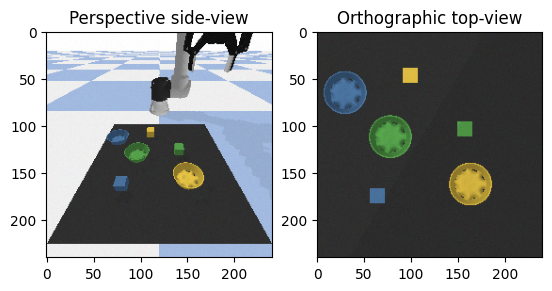

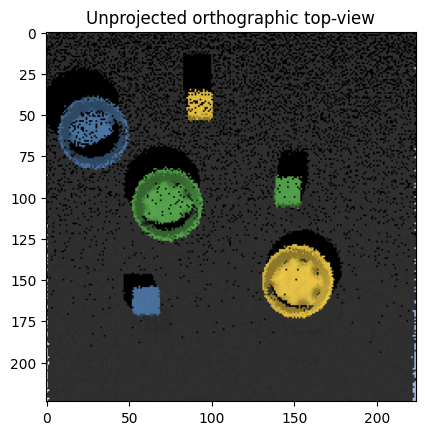

In [6]:
#@title Render images.

# Define and reset environment.
config = {'pick':  ['yellow block', 'green block', 'blue block'],
          'place': ['yellow bowl', 'green bowl', 'blue bowl']}

np.random.seed(42)
obs = env.reset(config)

plt.subplot(1, 2, 1)
img = env.get_camera_image()
plt.title('Perspective side-view')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = env.get_camera_image_top()
img = np.flipud(img.transpose(1, 0, 2))
plt.title('Orthographic top-view')
plt.imshow(img)
plt.show()

# Note: orthographic cameras do not exist. But we can approximate them by
# projecting a 3D point cloud from an RGB-D camera, then unprojecting that onto
# an orthographic plane. Orthographic views are useful for spatial action maps.
plt.title('Unprojected orthographic top-view')
plt.imshow(obs['image'])
plt.show()